# The Outcasts of Hollywood 

## Data Wrangling

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import gzip
import glob, os
from tqdm.auto import tqdm
tqdm.pandas()
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.formula.api as smf

import plotly.graph_objects as go
import plotly.express as px
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py

path = '../MovieSummaries/'

In [2]:
# Load various datasets
movies_db = pd.read_pickle(path + 'movies_db.pickle')
name_clusters = pd.read_pickle(path + 'name_clusters.pickle')
crew_basic = pd.read_csv(path + "imdb_crew.tsv", sep="\t")
name_basics = pd.read_csv(path + "imdb_name_basics.tsv", sep="\t")
movie_basics = pd.read_csv(path + "imdb_movie_basics.tsv", sep="\t", low_memory=False)
directors_sex = pd.read_csv(path + "git_all_directors_gender.csv", sep=",")
mainchar_budget = pd.read_csv(path + "kaggle_movies.csv", sep=",")

In [5]:
# Import summaries and join to movie
with open(path+'plot_summaries.txt') as infile:
    rawsum = infile.readlines()
    

sums = [t.split("\t") for t in rawsum]
sums_dict = {wiki_id: summary for wiki_id, summary in sums}
sums = pd.Series(sums_dict, name='summary')

#Check if all indexes are numbers (i.e shows if tab is a good seperator)
print('Are all indexes numerical ? : '+ str(all(ele.isdigit() for ele in sums.index)))

#Check for duplicates after converting from string to numeric (problem if '01234'=='1234')
sums.index = pd.to_numeric(sums.index)
print('Duplicates in summary index ? : ' + str(any(sums.index.duplicated())))
print(f'Number of movies: {len(movies_db)}\nNumber of summaries: {len(sums)}')

Are all indexes numerical ? : True
Duplicates in summary index ? : False
Number of movies: 81741
Number of summaries: 42306


In [7]:
#Join summaries to movies. Left join to keep all movies, or inner join to drop those without summaries
#validate raises MergeError when keys are not unique on both sides
#movies_sum = movies_db.merge(sums, how='left', left_on='wiki_id', right_index=True, validate='1:1')

## Preparation for interactive plots

## Preparation for NLP tasks

This section prepares the following methods: 

1. Identify role: A dataset containing the main role in movies was found. The issue with this dataset is that it does not contain movies released before 1980. Another approach would be using the NLP processed plot and count the number of times a character is cited in the plot. Therefore a ranking (most cited to less cited) can be applied assuming the main role is the most cited character in the Wikipedia plot.

2. Stereotypes in summaries: The NLP processed plots are parsed. First all the characters are retrieved thanks to named-entity recognition. Once all the characters are found, the interesting dependencies (amod, appos, nsubj…) involving the characters found are retrieved.  Pronouns are also used to describe a character and only using dependencies on names will be a loss of information. Therefore, coreferences will be used to assign pronouns to corresponding characters.

In [6]:
# Reading the data inside the xml file to a variable under the name data
nlp = pd.Series(dtype='object')

for filename in tqdm(glob.glob('../corenlp_plot_summaries/*.xml.gz')):
    with gzip.open(filename, 'r') as f:
        wikid = os.path.basename(filename)[0:-7] #get wiki_id with filename and remove extension
        data = f.read()
        nlp = pd.concat([nlp, pd.Series([data], index=[wikid])])
        
    

  0%|          | 0/42306 [00:00<?, ?it/s]

### Working on one plot before adding the loops into the file reading loop

In [7]:
# Passing the stored data inside the beautifulsoup parser, storing the returned object
soup = BeautifulSoup(data, "xml")

In [8]:
#Retrieving all characters
soup = BeautifulSoup(data, 'xml')
characters = soup.find_all(lambda tag: tag.name == "token" and 'PERSON' in tag.text)
names = []

for x in characters:
    names.append(x.find('word').text)

# Remove duplicates
names = list(set(names))

In [9]:
# Find all dependencies
deps = soup.find_all("collapsed-ccprocessed-dependencies")
char_deps = []
char_as_dep = []
char_as_gov = []
y = []

# Looping through names and through sentences
for name in names:
    for sentence in deps:
        
        #find when the name is classified as dependent and governor
        dependent = sentence.find_all(lambda tag: tag.name == "dep" and name in tag.dependent)
        governor = sentence.find_all(lambda tag: tag.name == "dep" and name in tag.governor)
        
        if dependent != []:
            char_as_dep += dependent
            
        if governor != []:
            char_as_gov += governor
            
# List of the characters dependencies

# List as dependent
char_desc_dep = []

for dep in char_as_dep:   
    if dep['type']=='nsubj' or dep['type']=='appos' \
        or dep['type']=='nsubjpass' :
        
        char_desc_dep.append(dep)

# List as governor
char_desc_gov = []

for gov in char_as_gov:
    if gov['type']=='rcmod' or gov['type']=='amod':
        char_desc_gov.append(gov)
        

## Ethnicity Data Processing

This section prepares the following method: 

3. Relationship between movie genre and ethnicity/genre of actors grouping the data based on the variables (i.e. ethnicity of director and grossing) and performing statistical tests 


### Data processing

In [11]:
# Load ethnicity query database containing corresponding ethnicity of every freebaseID code
ethnicity_query = pd.read_csv(path + "ethnicity_query.csv",sep=";" )
ethnicity_query.rename(columns = {'name': 'ethnicity_original'}, inplace = True)
ethnicity_query.head(10)

,item,freebaseID,ethnicity_original,ethnicity
0,http://www.wikidata.org/entity/Q22633,/m/038cy,Germanic peoples,NaN
1,http://www.wikidata.org/entity/Q26862,/m/03gq7tt,Hän people,NaN
2,http://www.wikidata.org/entity/Q43482,/m/07fswd,Franks,NaN
3,http://www.wikidata.org/entity/Q44949,/m/04mwbb,Bukharan Jews,NaN
4,http://www.wikidata.org/entity/Q35533,/m/05nsbj,Kaingang,NaN
5,http://www.wikidata.org/entity/Q39615,/m/0443q7,Krashovani,NaN
6,http://www.wikidata.org/entity/Q41477,/m/036p3f,Bubi people,NaN
7,http://www.wikidata.org/entity/Q43103,/m/02vsw1,European Americans,White
8,http://www.wikidata.org/entity/Q49306,/m/0630vt,Apalachee people,NaN
9,http://www.wikidata.org/entity/Q51705,/m/0fr3k,Muscogee,NaN


In [12]:
# Load and read DataFrame with lead roles of every movie after 1980
#mainchar_budget = pd.read_csv(path + "mainchar_budget.csv", sep= ",")
mainchar_budget.drop(['released'], axis =1, inplace = True)
mainchar_budget.head(10)

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
6,The Blues Brothers,R,Action,1980,7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133.0
7,Raging Bull,R,Biography,1980,8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0
8,Superman II,PG,Action,1980,6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,108185706.0,Dovemead Films,127.0
9,The Long Riders,R,Biography,1980,7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,15795189.0,United Artists,100.0


In [13]:
# Building characters DataFrame
characters_db = pd.read_csv(
    path+'character.metadata.tsv',
    sep='\t',
    header=None,
    names = ["wiki_movieID", "freebase_movieID", "release", "char_name", "dob", "gender", "height", "ethnicity", "act_name", "age_amr", "freebase_charmap"],
    index_col=False,
)

characters_db.head(10)

/var/folders/n6/lb3wydpx1t7d72t1r2nt_4r80000gn/T/ipykernel_3037/1268931089.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  characters_db = pd.read_csv(


,wiki_movieID,freebase_movieID,release,char_name,dob,gender,height,ethnicity,act_name,age_amr,freebase_charmap
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj


In [14]:
# Add ethnicity for each character in the database to characters_db DataFrame
characters_db = pd.merge(characters_db, ethnicity_query, left_on='ethnicity', right_on='freebaseID')
characters_db.drop(['freebaseID','release'], axis=1, inplace = True)
characters_db.rename(columns = {'ethnicity_y': 'ethnicity'}, inplace = True)
characters_db.drop('ethnicity_x', axis=1, inplace = True)
characters_db.head(10)

,wiki_movieID,freebase_movieID,char_name,dob,gender,height,act_name,age_amr,freebase_charmap,item,ethnicity_original,ethnicity
0,975900,/m/03vyhn,Tres,1959-03-09,M,NaN,Rodney A. Grant,42.0,/m/0bgchrs,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
1,8961059,/m/04j33ft,NaN,1959-03-09,M,NaN,Rodney A. Grant,38.0,/m/04j33fw,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
2,129585,/m/0y_9q,Wind In His Hair,1959-03-09,M,NaN,Rodney A. Grant,31.0,/m/02vb6zz,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
3,18616886,/m/04gnjpr,NaN,1959-03-09,M,NaN,Rodney A. Grant,38.0,/m/0h_05wr,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
4,244610,/m/01kff7,Hudson,1959-03-09,M,NaN,Rodney A. Grant,40.0,/m/0bygtv9,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
5,3097826,/m/08r81q,NaN,1959-03-09,M,NaN,Rodney A. Grant,39.0,/m/0glz1bk,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
6,5324114,/m/0dfmt6,NaN,1959-03-09,M,NaN,Rodney A. Grant,35.0,/m/02tb3bn,http://www.wikidata.org/entity/Q120601,Omaha people,Native American
7,2314463,/m/0734w5,NaN,1974-08-12,M,NaN,Arj Barker,31.0,/m/0cgnvt9,http://www.wikidata.org/entity/Q2643509,Indian Americans,South Asian
8,24863901,/m/09gnwkp,Actress,1976-02-26,F,1.68,Namrata Singh Gujral,33.0,/m/09j46w3,http://www.wikidata.org/entity/Q2643509,Indian Americans,South Asian
9,24863901,/m/09gnwkp,Breast Cancer Survivor,1976-02-26,F,1.68,Namrata Singh Gujral,33.0,/m/0h8248x,http://www.wikidata.org/entity/Q2643509,Indian Americans,South Asian


In [15]:
# Filter out main characters from characters_db
mainchar_budget_db = pd.merge(mainchar_budget, characters_db, left_on = 'star', right_on = 'act_name', how = 'inner')
mainchar_budget_db.head(10)

,name,rating,genre,year,score,votes,director,writer,star,country,...,char_name,dob,gender,height,act_name,age_amr,freebase_charmap,item,ethnicity_original,ethnicity
0,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,"Eugene Earl Axline, aka Harry Bliss",1937-04-22,M,1.77,Jack Nicholson,54.0,/m/0cg3hw2,http://www.wikidata.org/entity/Q974693,Italian Americans,White
1,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Brimmer,1937-04-22,M,1.77,Jack Nicholson,39.0,/m/03ls1f0,http://www.wikidata.org/entity/Q974693,Italian Americans,White
2,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,The Specialist,1937-04-22,M,1.77,Jack Nicholson,37.0,/m/03l0hb0,http://www.wikidata.org/entity/Q974693,Italian Americans,White
3,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Burnett,1937-04-22,M,1.77,Jack Nicholson,26.0,/m/03hdnh2,http://www.wikidata.org/entity/Q974693,Italian Americans,White
4,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Charlie Smith,1937-04-22,M,1.77,Jack Nicholson,44.0,/m/03l950l,http://www.wikidata.org/entity/Q974693,Italian Americans,White
5,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Freddy Gale,1937-04-22,M,1.77,Jack Nicholson,58.0,/m/03l928n,http://www.wikidata.org/entity/Q974693,Italian Americans,White
6,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Wilbur Force,1937-04-22,M,1.77,Jack Nicholson,23.0,/m/0k5r4k,http://www.wikidata.org/entity/Q974693,Italian Americans,White
7,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,Lt. Andre Duvalier,1937-04-22,M,1.77,Jack Nicholson,26.0,/m/0k6n0s,http://www.wikidata.org/entity/Q974693,Italian Americans,White
8,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,J. J. Gittes,1937-04-22,M,1.77,Jack Nicholson,37.0,/m/0jwcjk,http://www.wikidata.org/entity/Q974693,Italian Americans,White
9,The Shining,R,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,...,George Hanson,1937-04-22,M,1.77,Jack Nicholson,32.0,/m/0jxpr3,http://www.wikidata.org/entity/Q974693,Italian Americans,White


### Relationship between Protagonist and Ethnicity assessment

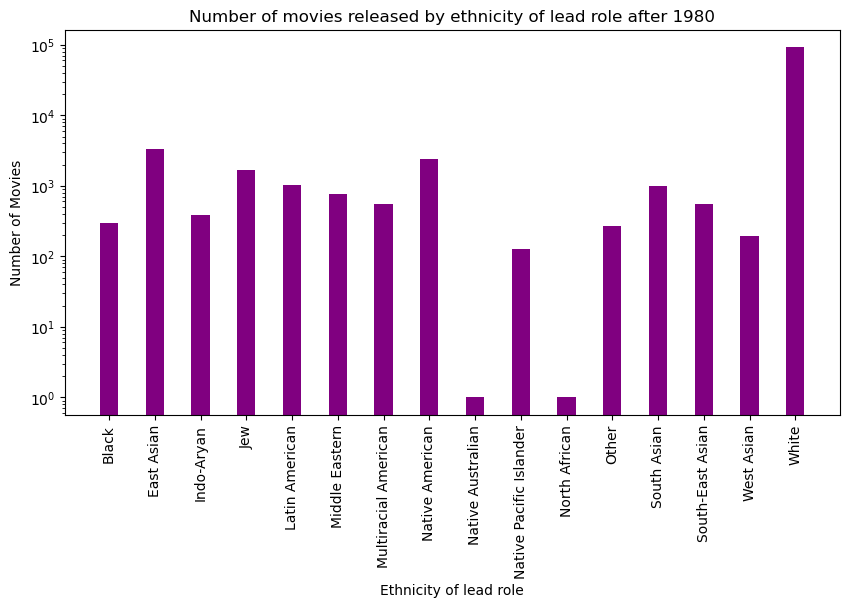

In [16]:
movie_num_by_ethnicity = mainchar_budget_db.groupby(by=["ethnicity"]).count()

# Plot the number of movies by ethnicity of lead role
fig = plt.figure(figsize = (10, 5))
 
# Creating the bar plot
plt.bar(movie_num_by_ethnicity.index , movie_num_by_ethnicity['name'] , color ='purple',
        width = 0.4)
plt.xticks(rotation = 90)
plt.semilogy()
plt.xlabel("Ethnicity of lead role")
plt.ylabel("Number of Movies")
plt.title("Number of movies released by ethnicity of lead role after 1980")
plt.show()

### Relationship between Protagonist and gender assessment

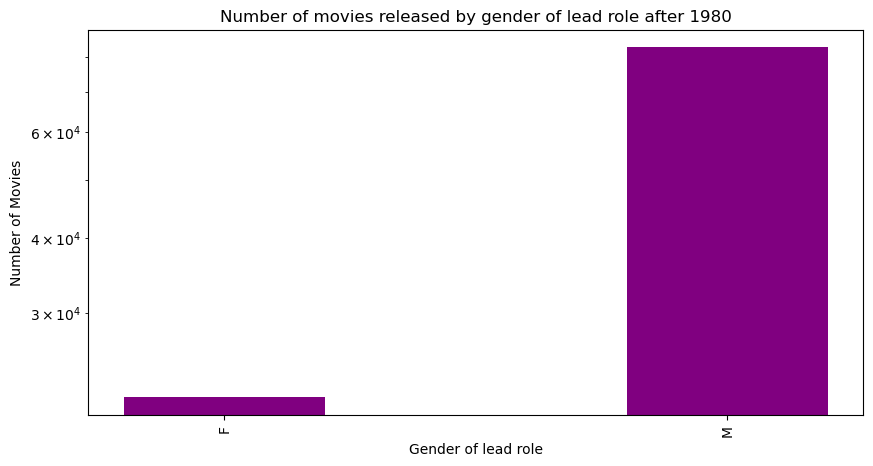

In [17]:
movie_num_by_gender = mainchar_budget_db.groupby(by=["gender"]).count()

# Plot the number of movies by ethnicity of lead role
fig = plt.figure(figsize = (10, 5))
 
# Creating the bar plot
plt.bar(movie_num_by_gender.index , movie_num_by_gender['name'] , color ='purple',
        width = 0.4)
plt.xticks(rotation = 90)
plt.semilogy()
plt.xlabel("Gender of lead role")
plt.ylabel("Number of Movies")
plt.title("Number of movies released by gender of lead role after 1980")
plt.show()

In [18]:
# Get the ethnicity of all actors in movies_db instead of the freebaseID ethnicity code
movies_ethnicity = pd.merge(characters_db, movies_db, on = 'freebase_movieID')
#movies_ethnicity.drop(['wiki_movieID_y', 'release_y','ethnicity_original'], axis = 1, inplace = True)
movies_ethnicity.rename(columns = {'wiki_movieID_x': 'wiki_movieID'}, inplace = True)
movies_ethnicity.rename(columns = {'release_x': 'release'}, inplace = True)
movies_ethnicity.head()

,wiki_movieID,freebase_movieID,char_name,dob,gender,height,act_name,age_amr,freebase_charmap,item,ethnicity_original,ethnicity,wiki_movieID_y,name,release,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Tres,1959-03-09,M,NaN,Rodney A. Grant,42.0,/m/0bgchrs,http://www.wikidata.org/entity/Q120601,Omaha people,Native American,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,8961059,/m/04j33ft,NaN,1959-03-09,M,NaN,Rodney A. Grant,38.0,/m/04j33fw,http://www.wikidata.org/entity/Q120601,Omaha people,Native American,8961059,White Wolves 3: Cry of The White Wolf,1998,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hj3mtj..."
2,129585,/m/0y_9q,Wind In His Hair,1959-03-09,M,NaN,Rodney A. Grant,31.0,/m/02vb6zz,http://www.wikidata.org/entity/Q120601,Omaha people,Native American,129585,Dances with Wolves,1990-10-19,424208848.0,224.0,"{""/m/0565z6"": ""Sioux language"", ""/m/06dqgy"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/0253g1"": ""Epic ..."
3,129585,/m/0y_9q,Toughest Pawnee,1947-12-17,M,1.83,Wes Studi,42.0,/m/03jsqb5,http://www.wikidata.org/entity/Q105405,Cherokee,Native American,129585,Dances with Wolves,1990-10-19,424208848.0,224.0,"{""/m/0565z6"": ""Sioux language"", ""/m/06dqgy"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/0253g1"": ""Epic ..."
4,129585,/m/0y_9q,Ten Bears,1936-08-17,M,NaN,Floyd Red Crow Westerman,54.0,/m/05ccmjc,http://www.wikidata.org/entity/Q107434,Sioux,Native American,129585,Dances with Wolves,1990-10-19,424208848.0,224.0,"{""/m/0565z6"": ""Sioux language"", ""/m/06dqgy"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/0253g1"": ""Epic ..."


## Gender of the crew

This section aims at answering the following research questions :

Does the proportion of movies with women in the crew cange with time

### Data processing

In [3]:
# Extract american movies
movies_usa = movies_db.loc[movies_db['countries']=='{"/m/09c7w0": "United States of America"}']

# Merge ImDB crew and movie info
crew_title = pd.merge(crew_basic, movie_basics, on = 'tconst')
crew_title.rename(columns = {'primaryTitle': 'name'}, inplace = True)

# Duplicates in the crew_title dataset are deleted
# Still difference with number of unique names -> group by name by aggregating to a list the other info
crew_title = crew_title[['name', 'directors', 'writers']].drop_duplicates().groupby("name").aggregate(lambda x: tuple(x))
movies_crew = movies_usa.merge(crew_title, on = 'name', how = 'inner')
movies_crew = movies_crew.dropna(subset = ['directors', 'writers'])

In [4]:
movies_crew.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,directors,writers
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","(nm0000118, \N, nm3973010)","(nm0837917,nm0000118, \N, nm4270124,nm3973010,..."


In [5]:
# Print info possibly lost 
print(f'Total movies at beginning: {len(movies_db)}')
print(f'Total american movies: {len(movies_usa)}')
print(f'After merge with crew info: {len(movies_crew)}')
print(f'\nSamples lost to have info on crew/director: {len(movies_usa) - len(movies_crew)}')

Total movies at beginning: 81741
Total american movies: 30300
After merge with crew info: 27784

Samples lost to have info on crew/director: 2516


In [6]:
# Add budget info
movies_budget = movies_crew.merge(directors_sex[['name', 'budget']], on = 'name')

# Add gender to name dataset - 
# Use of the ImdB dataset to get info on director and not just use of the directors_sex because it hase multiple 
# directors per movies and contains info on writers as well. Also, it is a more reliable source
directors_sex.rename(columns = {'director': 'primaryName'}, inplace = True)
name_genders = pd.merge(name_basics, directors_sex[['primaryName', 'gender']], on = 'primaryName')

In [7]:
# Add the presence of at least one women or all women in crew to DataFrame
women = name_genders[name_genders['gender']=='female']['nconst']
movies_crew['dir_one_fem'] = movies_crew['directors'].progress_apply(
    lambda x: any(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

  0%|          | 0/27784 [00:00<?, ?it/s]

In [8]:
movies_crew['dir_all_fem'] = movies_crew['directors'].progress_apply(
    lambda x: all(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

  0%|          | 0/27784 [00:00<?, ?it/s]

In [9]:
movies_crew['wri_one_fem'] = movies_crew['writers'].progress_apply(
    lambda x: any(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

  0%|          | 0/27784 [00:00<?, ?it/s]

In [10]:
movies_crew['wri_all_fem'] = movies_crew['writers'].progress_apply(
    lambda x: all(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

  0%|          | 0/27784 [00:00<?, ?it/s]

In [11]:
movies_crew.head(5)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,directors,writers,dir_one_fem,dir_all_fem,wri_one_fem,wri_all_fem
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","(nm0000118, \N, nm3973010)","(nm0837917,nm0000118, \N, nm4270124,nm3973010,...",False,False,False,False
1,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...","(nm0499883, nm0727225, nm4215028, \N, nm5698891)","(nm0629243, nm0727225, nm4215028, \N, nm5698891)",False,False,False,False
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...","(nm0281487, nm0281487,nm0191386, nm0454771)","(\N, \N, nm0778636,nm0873707,nm0792553,nm00009...",False,False,False,False
3,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...","(nm0002188,)","(nm0015399,nm0790352,)",False,False,False,False
4,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","(nm0281487,nm0611157,)","(nm0795975,nm0796950,nm0816917,nm0460667,)",False,False,False,False


### Does the proportion of movies with ethnic people/women in the crew change with time ?

In [80]:
# Extract the year out of the date 
movies_crew['year'] = pd.to_datetime(movies_crew['release']).apply(lambda x: x.year)
movies_crew = movies_crew.dropna(subset=['year'])

/tmp/ipykernel_9715/459615284.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
# Build specific DataFrames
# For this part, wa refers to at least one woman, w to all women, m to all men
# In terms of the directors
movies_dir_wa = movies_crew[movies_crew['dir_one_fem']==True]
movies_dir_w = movies_crew[movies_crew['dir_all_fem']==True]
movies_dir_m = movies_crew[movies_crew['dir_one_fem']==False]
# In terms of the writers
movies_wri_wa = movies_crew[movies_crew['wri_one_fem']==True]
movies_wri_w = movies_crew[movies_crew['wri_all_fem']==True]
movies_wri_m = movies_crew[movies_crew['wri_one_fem']==False]
# In terms of whole crew 
movies_crew['crew_one_fem'] = movies_crew['wri_one_fem'].apply(lambda x: int(x)) + movies_crew['dir_one_fem'].apply(lambda x: int(x)) > 0
movies_wa = pd.concat([ movies_crew[movies_crew['wri_one_fem']==True] , movies_crew[movies_crew['dir_one_fem']==True]])
movies_w = movies_crew[movies_crew['wri_all_fem']==True][movies_crew['dir_all_fem']==True]
movies_m = movies_crew[movies_crew['wri_one_fem']==False][movies_crew['dir_one_fem']==False]

/tmp/ipykernel_9715/22750684.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_9715/22750684.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [83]:
tot = len(movies_crew)
# Check proportions of women directors
print('Number of movies directed by all women: ' + f"{len(movies_dir_w)}" + " == " + "{:.2%}".format(len(movies_dir_w) / tot) + " of total movies in dataset")
print('Number of movies directed by at least one woman: ' + f"{len(movies_dir_wa)}" + " == " + "{:.2%}".format(len(movies_dir_wa) / tot) + " of total movies in dataset")
print('Number of movies directed by all men: ' + f"{len(movies_dir_m)}" + " == " + "{:.2%}".format(len(movies_dir_m) / tot) +  " of total movies in dataset")

# Check proportions of women writters
print('\nNumber of movies written by all women: ' + f"{len(movies_wri_w)}" + " == " + "{:.2%}".format(len(movies_wri_w) / tot) + " of total movies in dataset")
print('Number of movies written by at least one woman: ' + f"{len(movies_wri_wa)}" + " == " + "{:.2%}".format(len(movies_wri_wa) / tot) + " of total movies in dataset")
print('Number of movies written by all men: ' + f"{len(movies_wri_m)}" + " == " + "{:.2%}".format(len(movies_wri_m) / tot) + " of total movies in dataset")

# Check proportions of women crew members
print('\nNumber of movies written and directed by women: ' + f"{len(movies_w)}" + " == " + "{:.2%}".format(len(movies_w) / tot) + " of total movies in dataset")
print('Number of movies written and directed by at least one woman: ' + f"{len(movies_wa)}" + " == " + "{:.2%}".format(len(movies_wa) / tot) + " of total movies in dataset")
print('Number of movies written and directed by all men: ' + f"{len(movies_m)}" + " == " + "{:.2%}".format(len(movies_m) / tot) + " of total movies in dataset")

Number of movies directed by all women: 0 == 0.00% of total movies in dataset
Number of movies directed by at least one woman: 776 == 2.89% of total movies in dataset
Number of movies directed by all men: 26071 == 97.11% of total movies in dataset

Number of movies written by all women: 0 == 0.00% of total movies in dataset
Number of movies written by at least one woman: 480 == 1.79% of total movies in dataset
Number of movies written by all men: 26367 == 98.21% of total movies in dataset

Number of movies written and directed by women: 0 == 0.00% of total movies in dataset
Number of movies written and directed by at least one woman: 1256 == 4.68% of total movies in dataset
Number of movies written and directed by all men: 25855 == 96.30% of total movies in dataset


#### Plot the yearly evolution

In [103]:
# yearly releases of movies 
tot = movies_crew.groupby('year').aggregate('count')['wiki_movieID']
# Yearly releases of movies directed by men/women 
plot_w_d = movies_crew.groupby('year').aggregate(sum)['dir_all_fem'] 
plot_wa_d = movies_crew.groupby('year').aggregate(sum)['dir_one_fem']  
# Yearly releases of movies written by men/women 
plot_w_w = movies_crew.groupby('year').aggregate(sum)['wri_all_fem']
plot_wa_w = movies_crew.groupby('year').aggregate(sum)['wri_one_fem']  
# Yearly releases of movies containing at least one woman in the crew
plot_wa = movies_crew.groupby('year').aggregate(sum)['crew_one_fem']  
plot_m = tot - plot_wa

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_wa_d.index, y=plot_wa_d/tot*100, name='At least one woman director',
                         line=dict(color='#72B7B2', width=4)))

fig.add_trace(go.Scatter(x=plot_wa_w.index, y=plot_wa_w/tot*100, name='At least one woman writer',
                         line=dict(color='#9467BD', width=4, dash='dot')))


fig.add_trace(go.Scatter(x=plot_wa.index, y=plot_wa/tot*100, name='At least one woman in the crew',
                         line=dict(color='#E45756', width=4, dash='dash')))

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

#### Statstical tests

In [105]:
stats.ttest_ind(plot_wa_d, plot_m_d)

Ttest_indResult(statistic=array([-15.42444043, -15.42444043, -15.42444043, -15.42444043,
        -7.67165453, -13.60889187, -15.42444043, -15.42444043,
       -15.42444043, -15.42444043, -15.42444043, -15.42444043,
       -15.42444043, -15.42444043, -15.42444043]), pvalue=array([6.28966627e-38, 6.28966627e-38, 6.28966627e-38, 6.28966627e-38,
       4.05076272e-13, 9.22246377e-32, 6.28966627e-38, 6.28966627e-38,
       6.28966627e-38, 6.28966627e-38, 6.28966627e-38, 6.28966627e-38,
       6.28966627e-38, 6.28966627e-38, 6.28966627e-38]))

In [106]:
stats.ttest_ind(plot_wa_w, plot_m_w)

Ttest_indResult(statistic=array([-15.49437858, -15.49437858, -15.49437858, -15.49437858,
        -8.22999938, -13.71733337, -15.49437858, -15.49437858,
       -15.49437858, -15.49437858, -15.49437858, -15.49437858,
       -15.49437858, -15.49437858, -15.49437858]), pvalue=array([3.63443907e-38, 3.63443907e-38, 3.63443907e-38, 3.63443907e-38,
       1.13038438e-14, 3.96620476e-32, 3.63443907e-38, 3.63443907e-38,
       3.63443907e-38, 3.63443907e-38, 3.63443907e-38, 3.63443907e-38,
       3.63443907e-38, 3.63443907e-38, 3.63443907e-38]))

In [104]:
stats.ttest_ind(plot_wa, plot_m)

Ttest_indResult(statistic=-15.276404430047506, pvalue=2.008056206958432e-37)

## Revenue comparison 

Is there a noticeable difference in revenue for movies that portray some particular ethnicities/genre? Is there a noticeable difference in revenue for movies created by women ?

In [114]:
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(movies_crew, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

In [131]:
# Correlation between gender of director and revenue
movie_stats = movies_crew[['crew_one_fem', 'revenue']].dropna()
stats.pearsonr(movie_stats['crew_one_fem'], movie_stats['revenue'])
# There is a significant correlation BUT small

(0.03100699649850429, 0.02433444766575075)

#### Budget comparison

In [116]:
# Adding budget
mainchar_budget.head(1)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0


In [126]:
movies_budget = pd.merge(movies_crew, mainchar_budget, on = 'name')

In [143]:
# Info lost 
print(f'Total movies at beginning: {len(movies_crew)}')
#print(f'Total of movies with renevue inforamtion: {len(movies_crew.dropna(subset=['revenue']))}')
print(f'After merge with budget info: {len(movies_budget)}')
print(f'\nSamples lost to have info on budget/revenue: {len(movies_crew) - len(movies_budget)}')

Total movies at beginning: 26847
After merge with budget info: 2650

Samples lost to have info on budget/revenue: 24197


In [124]:
# Correlation between budget and gender of crew
movie_stats = movies_budget[['budget', 'crew_one_fem']].dropna()
stats.pearsonr(movie_stats['budget'], movie_stats['crew_one_fem'])
# There is a significant correlation BUT it is very small 

(-0.029189956480634494, 0.07850654468147933)

In [125]:
# Correlation between budget and revenue
movie_stats = movies_budget[['budget', 'revenue']].dropna()
stats.pearsonr(movie_stats['revenue'], movie_stats['budget'])
# There is a significant correlation

(0.615830260503957, 1.6800487969864734e-276)

#### Matching revenue with budget

In [36]:
movies_budget.columns

Index(['wiki_movieID', 'freebase_movieID', 'name', 'release', 'revenue',
       'runtime_x', 'languages', 'countries', 'genres', 'directors', 'writers',
       'dir_one_fem', 'dir_all_fem', 'wri_one_fem', 'wri_all_fem', 'rating',
       'genre', 'year', 'released', 'score', 'votes', 'director', 'writer',
       'star', 'country', 'budget', 'gross', 'company', 'runtime_y'],
      dtype='object')

In [127]:
# Preprocess movie_budget df
movies_budget = movies_budget.dropna(subset=['revenue', 'budget', 'dir_one_fem'])
movies_budget['dir_one_fem'] = movies_budget['dir_one_fem'].apply(lambda x: int(x))
m = movies_budget['budget'].mean() # keep the mean and std to be able to reconstruct the real values
s = movies_budget['budget'].std()
movies_budget['budget'] = (movies_budget['budget'] - m)/s # standardize the continous budget feature 

In [133]:
# Separate in the two groups to be matched (at least one women, only men)
wa = movies_budget[movies_budget['crew_one_fem'] == 1]
m = movies_budget[movies_budget['crew_one_fem'] == 0]

# Estimate the propensity score
mod = smf.logit(formula='dir_one_fem ~ budget', data=movies_budget)
res = mod.fit()

# Extract the estimated propensity scores
movies_budget['Propensity_score'] = res.predict()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.288207
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            dir_one_fem   No. Observations:                 2650
Model:                          Logit   Df Residuals:                     2648
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Dec 2022   Pseudo R-squ.:                0.002025
Time:                        14:22:01   Log-Likelihood:                -763.75
converged:                       True   LL-Null:                       -765.30
Covariance Type:            nonrobust   LLR p-value:                   0.07829
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3943      0.070    -33.974      0.000      -2.532      -2.256
budget        -0.1348      0.

In [134]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [157]:
# Create an empty undirected graph
G = nx.Graph()
i = -1
j = -1
# Loop through all the pairs of instances
for m_id, m_row in m.iterrows():
    i = i+1
    for wa_id, wa_row in wa.iterrows():
        j = j+1
        # Calculate the similarity 
        similarity = get_similarity(m_row['Propensity_score'],
                                    wa_row['Propensity_score'])
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(i, j, similarity)])

In [ ]:
# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
print(len(movies_budget))
print(matched)

In [154]:
balanced_movies_budget_dir = movies_budget.iloc[i]

In [ ]:
# Perform an ordinary least squares linear regression
results = smf.ols('revenue ~ budget + crew_one_fem', data=matched_df).fit()
results.summary()

In [ ]:
# Plot revenue distribution comparison between gender of the director
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(movies_crew, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

In [ ]:
# Correlation between budget and gender of crew
movie_stats = movies_budget[['budget', 'crew_one_fem']].dropna()
stats.pearsonr(movie_stats['budget'], movie_stats['dir_one_fem'])
# There is a significant correlation BUT it is very small 

In [ ]:
# Correlation between budget and revenue
movie_stats = movies_budget[['budget', 'revenue']].dropna()
stats.pearsonr(movie_stats['revenue'], movie_stats['budget'])
# There is a significant correlation